# Setup

In [7]:
import os
import shutil
import random
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
#from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import sampler

to_float = torch.float
to_long = torch.long

if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')
print(device)

cpu


# 定义网络模型

In [11]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.net = nn.Sequential(
            #3*32*32
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            #16*16*16
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            #32*8*8
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            #64*4*4
            nn.Flatten(),
            nn.Linear(64*4*4, 500),
            nn.ReLU(),
            
            nn.Linear(500, 6),
        )
        
    def forward(self, x):
        return self.net(x)
# model = Net()
# print(model)
# optimizer = optim.SGD(model.parameters(), lr=0.01)

Net(
  (net): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=1024, out_features=500, bias=True)
    (11): ReLU()
    (12): Linear(in_features=500, out_features=6, bias=True)
  )
)


# 打印准确率函数

In [12]:
def check_accuracy_part34(loader, model):
  #if loader.dataset.train:
  #  print('Checking accuracy on validation set')
  #else:
  #  print('Checking accuracy on test set')   
  num_correct = 0
  num_samples = 0
  model.eval()  # set model to evaluation mode
  with torch.no_grad():
    for x, y in loader:
      x = x.to(device=device, dtype=to_float)  # move to device, e.g. GPU
      y = y.to(device=device, dtype=to_long).clamp(max=5)
      scores = model(x)
      _, preds = scores.max(1)
      num_correct += (preds == y).sum()
      num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
  return acc

# 加载数据集

In [5]:
train_data = datasets.ImageFolder('/home/dawn/文档/RecCifar10/cifar-10/train')
test_data = datasets.ImageFolder('/home/dawn/文档/RecCifar10/cifar-10/test')

# 随机提取6类训练5次，最终结果取平均

In [26]:
main_dir = os.getcwd()
train_dir = main_dir + "/extract_train"
test_dir = main_dir + "/extract_test"

epochs = 1
total = []

for i in range(5):
    #建立存放数据集的文件夹
    if os.path.exists(train_dir) and os.path.exists(test_dir):
        shutil.rmtree(train_dir)
        shutil.rmtree(test_dir)
        os.mkdir(train_dir)
        os.mkdir(test_dir)
    else:
        os.mkdir(train_dir)
        os.mkdir(test_dir)
        
    #生成6个随机数，用于提取数据集中的6类
    class_6 = torch.randperm(10)[:6]
    print("Extract classes: ", class_6, "\n")

    #提取6类并保存至新的文件夹
    for i in range(50000):
        train_label = train_data.imgs[i][1]

        if train_label in class_6:
            train_label_dir = train_dir + "/" + str(train_label)
            if os.path.exists(train_label_dir):
                pass
            else:
                os.mkdir(train_label_dir)
            image_path = train_data.imgs[i][0]
            image = Image.open(image_path)
            save_path = train_label_dir + "/" + str(i) + ".jpg"
            image.save(save_path)

    for i in range(10000):
        test_label = test_data.imgs[i][1]

        if test_label in class_6:
            test_label_dir = test_dir + "/" + str(test_label)
            if os.path.exists(test_label_dir):
                pass
            else:
                os.mkdir(test_label_dir)
            image_path = test_data.imgs[i][0]
            image = Image.open(image_path)
            save_path = test_label_dir + "/" + str(i) + ".jpg"
            image.save(save_path)
            
    #定义预处理操作
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
        ])

    #数据集预处理
    train_data_ = datasets.ImageFolder(train_dir, transform=transform)
    test_data_ = datasets.ImageFolder(test_dir, transform=transform)

    #数据集采样、打包
    n_train = len(train_data_)  #30000

    split = 21000
    indices = list(range(n_train))
    random.shuffle(indices)

    train_loader = torch.utils.data.DataLoader(train_data_, batch_size=64, 
                                              sampler=sampler.SubsetRandomSampler(indices[:split]))
    valid_loader = torch.utils.data.DataLoader(train_data_, batch_size=64, 
                                            sampler=sampler.SubsetRandomSampler(indices[split:]))
    test_loader = torch.utils.data.DataLoader(test_data_, batch_size=64, shuffle=True)
    
    #定义网络与参数更新方法
    model = Net()
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    
    #训练网络
    num_prints = epochs * len(train_loader) // 100 + 1
    acc_history = torch.zeros(num_prints, dtype=to_float)
    iter_history = torch.zeros(num_prints, dtype=to_long)
    model = model.to(device=device)# move the model parameters to CPU/GPU
    for epoch in range(epochs):
        for t, (x, y) in enumerate(train_loader):
            model.train()
            # Move the data to the proper device (GPU or CPU)
            x = x.to(device=device, dtype=to_float)
            y = y.to(device=device, dtype=to_long).clamp(max=5)

            # Forward pass: compute scores and loss
            scores = model(x)
            loss = F.cross_entropy(scores, y)

            optimizer.zero_grad()

            #Backwards pass: compute the gradient
            loss.backward()

            #Update the parameters
            optimizer.step()

            tt = t + epoch * len(train_loader)

            if tt % 100 == 0 or (epoch == epochs - 1 and t == len(train_loader) - 1):
                print("Epoch: %d, Iteration: %d, loss = %.4f" %(epoch, tt, loss.item()))
                acc = check_accuracy_part34(valid_loader, model)
                acc_history[tt // 100] = acc
                iter_history[tt // 100] = tt
                print()
    total.append(acc_history[-1])
    
final_acc = sum(total) / len(total) * 100
print("Final accuracy: %.2f" %final_acc)

Extract classes:  tensor([6, 3, 1, 5, 4, 9]) 

Epoch: 0, Iteration: 0, loss = 1.7911
Got 1451 / 9000 correct (16.12)

Epoch: 0, Iteration: 100, loss = 1.7900
Got 1676 / 9000 correct (18.62)

Epoch: 0, Iteration: 200, loss = 1.7858
Got 2263 / 9000 correct (25.14)

Epoch: 0, Iteration: 300, loss = 1.7784
Got 2024 / 9000 correct (22.49)

Epoch: 0, Iteration: 328, loss = 1.7921
Got 2074 / 9000 correct (23.04)

Extract classes:  tensor([3, 7, 5, 8, 1, 9]) 

Epoch: 0, Iteration: 0, loss = 1.7961
Got 1561 / 9000 correct (17.34)

Epoch: 0, Iteration: 100, loss = 1.7805
Got 1562 / 9000 correct (17.36)

Epoch: 0, Iteration: 200, loss = 1.7665
Got 2280 / 9000 correct (25.33)

Epoch: 0, Iteration: 300, loss = 1.7554
Got 2545 / 9000 correct (28.28)

Epoch: 0, Iteration: 328, loss = 1.7452
Got 2381 / 9000 correct (26.46)

Extract classes:  tensor([3, 9, 8, 6, 0, 7]) 

Epoch: 0, Iteration: 0, loss = 1.7949
Got 1448 / 9000 correct (16.09)

Epoch: 0, Iteration: 100, loss = 1.7887
Got 1816 / 9000 correc

# 随机提取6类进行单次训练

## 数据集加载

In [9]:
#定义预处理操作
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
    ])

#数据集预处理
train_data_ = datasets.ImageFolder(train_dir, transform=transform)
test_data_ = datasets.ImageFolder(test_dir, transform=transform)

#数据集采样、打包
n_train = len(train_data_)  #30000

split = 21000
indices = list(range(n_train))
random.shuffle(indices)

train_loader = torch.utils.data.DataLoader(train_data_, batch_size=64, 
                                          sampler=sampler.SubsetRandomSampler(indices[:split]))
valid_loader = torch.utils.data.DataLoader(train_data_, batch_size=64, 
                                        sampler=sampler.SubsetRandomSampler(indices[split:]))
test_loader = torch.utils.data.DataLoader(test_data_, batch_size=64, shuffle=True)

## 训练网络

In [31]:
#定义网络与参数更新方法
model = Net()
optimizer = optim.SGD(model.parameters(), lr=0.01)

epochs = 30
num_prints = epochs * len(train_loader) // 100 + 1
acc_history = torch.zeros(num_prints, dtype=to_float)
iter_history = torch.zeros(num_prints, dtype=to_long)
model = model.to(device=device)# move the model parameters to CPU/GPU
for epoch in range(epochs):
    for t, (x, y) in enumerate(train_loader):
        model.train()
        # Move the data to the proper device (GPU or CPU)
        x = x.to(device=device, dtype=to_float)
        y = y.to(device=device, dtype=to_long).clamp(max=5)
        
        # Forward pass: compute scores and loss
        scores = model(x)
        loss = F.cross_entropy(scores, y)
        
        optimizer.zero_grad()
        
        #Backwards pass: compute the gradient
        loss.backward()
        
        #Update the parameters
        optimizer.step()
        
        tt = t + epoch * len(train_loader)
        
        if tt % 100 == 0 or (epoch == epochs - 1 and t == len(train_loader) - 1):
            print("Epoch: %d, Iteration: %d, loss = %.4f" %(epoch, tt, loss.item()))
            acc = check_accuracy_part34(valid_loader, model)
            acc_history[tt // 100] = acc
            iter_history[tt // 100] = tt
            print()

Epoch: 0, Iteration: 0, loss = 1.7890
Got 1505 / 9000 correct (16.72)

Epoch: 0, Iteration: 100, loss = 1.7794
Got 2636 / 9000 correct (29.29)

Epoch: 0, Iteration: 200, loss = 1.7616
Got 2292 / 9000 correct (25.47)

Epoch: 0, Iteration: 300, loss = 1.7209
Got 2923 / 9000 correct (32.48)

Epoch: 1, Iteration: 400, loss = 1.6462
Got 3072 / 9000 correct (34.13)

Epoch: 1, Iteration: 500, loss = 1.4225
Got 3261 / 9000 correct (36.23)

Epoch: 1, Iteration: 600, loss = 1.5210
Got 3403 / 9000 correct (37.81)

Epoch: 2, Iteration: 700, loss = 1.4118
Got 3630 / 9000 correct (40.33)

Epoch: 2, Iteration: 800, loss = 1.2976
Got 3631 / 9000 correct (40.34)

Epoch: 2, Iteration: 900, loss = 1.3876
Got 3847 / 9000 correct (42.74)

Epoch: 3, Iteration: 1000, loss = 1.3592
Got 4048 / 9000 correct (44.98)

Epoch: 3, Iteration: 1100, loss = 1.2128
Got 4164 / 9000 correct (46.27)

Epoch: 3, Iteration: 1200, loss = 1.2877
Got 4397 / 9000 correct (48.86)

Epoch: 3, Iteration: 1300, loss = 1.0491
Got 4404 

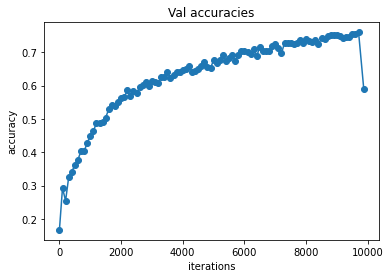

In [32]:
import matplotlib.pyplot as plt
plt.title('Val accuracies')
plt.plot(iter_history, acc_history, '-o')
plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.show()